In [1]:
import eland as ed
import numpy as np
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="ASML"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_ema = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')
df_ema['ema_10'] = df_ema['val_close'].ewm(span=10, adjust=False).mean()
df_ema['ema_20'] = df_ema['val_close'].ewm(span=20, adjust=False).mean()

In [4]:
df_ema.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,ema_10,ema_20
date_reference,,,,,,,,
2025-10-17,ASML,1029.270,1032.765,1015.00,1020.590,1663654,998.624965,971.714681
2025-10-20,ASML,1042.150,1052.170,1031.49,1031.750,1271713,1006.538607,978.422807
2025-10-21,ASML,1025.020,1037.475,1024.15,1036.305,1072158,1009.898861,982.860635
2025-10-22,ASML,1011.565,1033.180,997.67,1026.450,1328598,1010.201795,985.594384
2025-10-23,ASML,1036.410,1040.500,1004.50,1004.520,1318221,1014.966923,990.433966


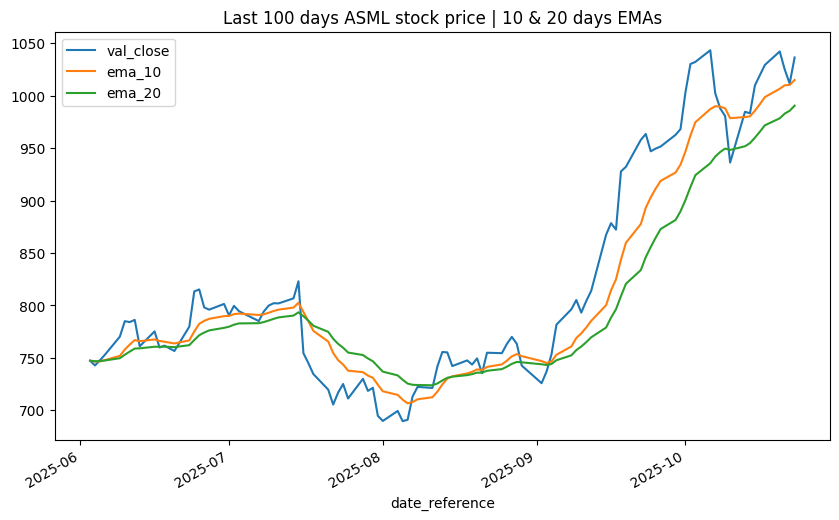

In [5]:
df_ema[["val_close", "ema_10", "ema_20"]].plot(title=f"Last 100 days {ticker} stock price | 10 & 20 days EMAs", figsize=(10, 6));

In [6]:
df_ema['position'] = np.where(df_ema['ema_10'] > df_ema['ema_20'], 1, -1)
df_ema.dropna(inplace=True)

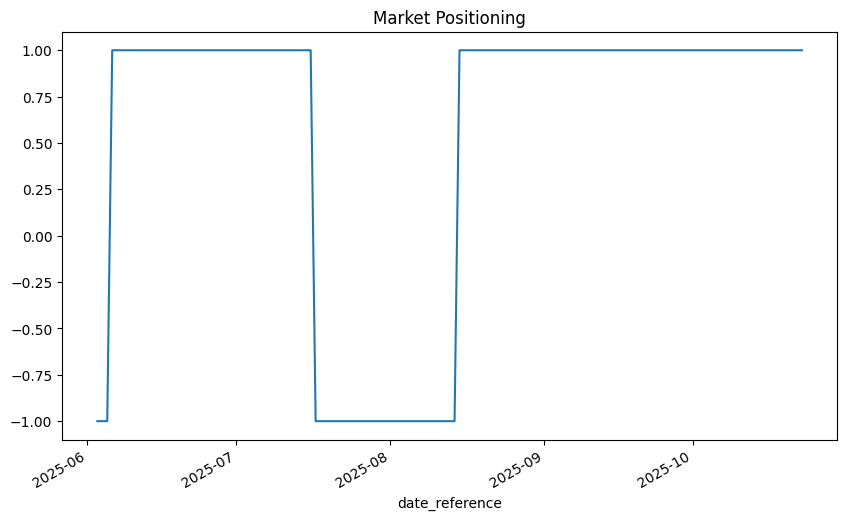

In [7]:
df_ema['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_ema['returns'] = np.log(df_ema['val_close'] / df_ema['val_close'].shift(1))
df_ema['strategy'] = df_ema['position'].shift(1) * df_ema['returns']
df_ema[['returns', 'strategy']].sum().apply(np.exp)

returns     1.386966
strategy    1.375932
dtype: float64

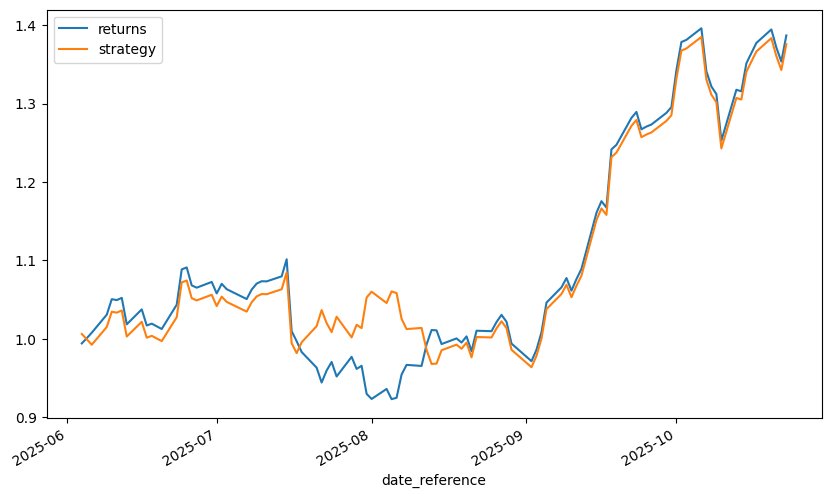

In [9]:
df_ema[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [10]:
df_ema['prev_position'] = df_ema['position'].shift(1)
crossovers = df_ema[df_ema['position'] != df_ema['prev_position']]
print(crossovers[['val_close', 'ema_10', 'ema_20', 'position']])

                val_close      ema_10      ema_20  position
date_reference                                             
2025-06-03         747.25  747.250000  747.250000        -1
2025-06-06         753.02  747.830902  747.494982         1
2025-07-17         744.91  784.876024  785.443497        -1
2025-08-15         742.16  732.375485  732.035177         1
